# HDSoC / Nalu Event Exploration

Use this notebook after unpacking with `--profile HDSoC`.

In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import os

plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['axes.grid'] = True

DATA_FILE = os.getenv('NALU_OUTPUT', '../../output.root')
LIB_DIR = '../../build/lib'

In [2]:
required_libs = [
    'libanalysis_pipeline_core.so',
    'libunpacker_data_products_core.so',
    'libunpacker_data_products_nalu.so'
]
for lib in required_libs:
    path = os.path.join(LIB_DIR, lib)
    if os.path.exists(path):
        ROOT.gSystem.Load(path)
    else:
        print(f'Warning: {lib} not found in {LIB_DIR}')

In [3]:
file = ROOT.TFile.Open(DATA_FILE)
if not file or file.IsZombie():
    raise RuntimeError(f'Unable to open ROOT file: {DATA_FILE}')

tree = file.Get('events')
if not tree:
    raise RuntimeError("Tree 'events' not found in file")

print(f'Total events: {tree.GetEntries()}')
print('Branches:', [branch.GetName() for branch in tree.GetListOfBranches()])

Total events: 2559
Branches: ['nalu_event', 'nalu_time']


In [4]:
def fetch_event(entry):
    if entry < 0 or entry >= tree.GetEntries():
        raise IndexError(f'Entry {entry} out of range (0-{tree.GetEntries()-1})')
    tree.GetEntry(entry)
    return tree.nalu_event, getattr(tree, 'nalu_time', None)

In [5]:
def summarise_event(entry=0):
    event, timing = fetch_event(entry)
    print(f'Event {entry}')
    if hasattr(event, 'header'):
        hdr = event.header
        for field in ['event_id', 'timestamp', 'n_packets', 'crate_id', 'board_id']:
            if hasattr(hdr, field):
                print(f'  header.{field}: {getattr(hdr, field)}')
    packet_count = len(event.packets.packets) if hasattr(event.packets, 'packets') else 'n/a'
    print(f'  packets: {packet_count}')
    waveform_count = len(event.waveforms.waveforms) if hasattr(event.waveforms, 'waveforms') else 'n/a'
    print(f'  waveforms: {waveform_count}')
    if timing:
        print('  timing info present:')
        for attr in ['cycle_id', 'timestamp', 'coarse_clock']:
            if hasattr(timing.time, attr):
                print(f'    timing.{attr}: {getattr(timing.time, attr)}')
summarise_event(0)

Event 0
  packets: 16
  waveforms: 2
  timing info present:


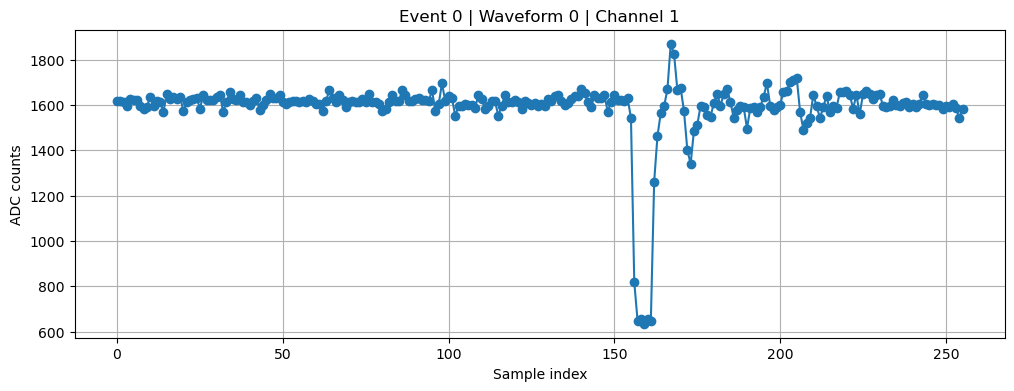

In [6]:
def plot_waveform(entry=0, waveform_index=0, normalise=False):
    event, _ = fetch_event(entry)
    waveforms = getattr(event.waveforms, 'waveforms', [])
    if not waveforms:
        print(f'Event {entry} has no reconstructed waveforms')
        return
    if waveform_index < 0 or waveform_index >= len(waveforms):
        print(f'Waveform index {waveform_index} out of range (0-{len(waveforms)-1})')
        return
    wf = waveforms[waveform_index]
    trace = np.asarray(wf.trace, dtype=np.float32)
    if normalise and trace.size > 0:
        span = trace.max() - trace.min()
        trace = (trace - trace.min()) / span if span else trace * 0
    plt.figure(figsize=(12, 4))
    plt.plot(trace, marker='o', linestyle='-')
    plt.title(f'Event {entry} | Waveform {waveform_index} | Channel {wf.channel_num}')
    plt.xlabel('Sample index')
    plt.ylabel('ADC counts' if not normalise else 'Normalised amplitude')
    plt.show()
plot_waveform(0, 0)

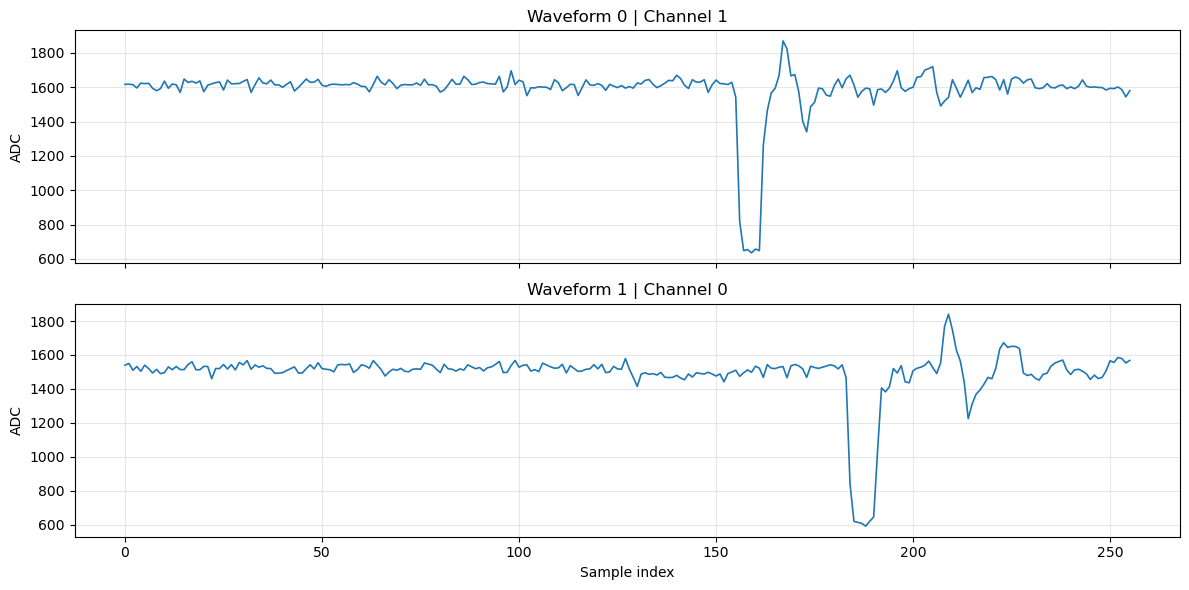

In [7]:
def plot_event_waveforms(entry=0, max_waveforms=4):
    event, _ = fetch_event(entry)
    waveforms = getattr(event.waveforms, 'waveforms', [])
    if not waveforms:
        print(f'Event {entry} has no reconstructed waveforms')
        return
    count = min(len(waveforms), max_waveforms)
    fig, axes = plt.subplots(count, 1, figsize=(12, 3 * count), sharex=True)
    if count == 1:
        axes = [axes]
    for idx in range(count):
        wf = waveforms[idx]
        axes[idx].plot(np.asarray(wf.trace, dtype=np.float32), linewidth=1.2)
        axes[idx].set_title(f'Waveform {idx} | Channel {wf.channel_num}')
        axes[idx].set_ylabel('ADC')
        axes[idx].grid(True, alpha=0.3)
    axes[-1].set_xlabel('Sample index')
    plt.tight_layout()
    plt.show()
plot_event_waveforms(0, max_waveforms=3)

### Next steps

- Iterate over events and export waveforms for further offline analysis.
- Combine the `summarise_event` output with detector-specific QA metrics.
- Extend this notebook with additional plots derived from `NaluTime` data.